# Load model and weights

In [3]:
from keras.models import load_model
import keras.backend as K
from keras.losses import binary_crossentropy
import numpy as np

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    return K.mean((2. * intersection + smooth) / (union + smooth), axis=0)


def dice_p_bce(in_gt, in_pred):
    return 1e-3 * binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true) * K.flatten(K.round(y_pred))) / K.sum(y_true)

def IoU(y_true, y_pred, eps=1e-6):
    if np.max(y_true) == 0.0:
        return IoU(1 - y_true, 1 - y_pred)  ## empty image; calc IoU of zeros
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    return -K.mean((intersection + eps) / (union + eps), axis=0)


model = load_model("models/segmentation_model_final_v1.h5",
                   custom_objects={'dice_p_bce': dice_p_bce, 'dice_coef': dice_coef,

                                   'true_positive_rate': true_positive_rate,
                                   'IoU': IoU})


# Notebook settings

In [5]:
PICTURES = None
NR_PICTURES = 10
VISUALIZE = True

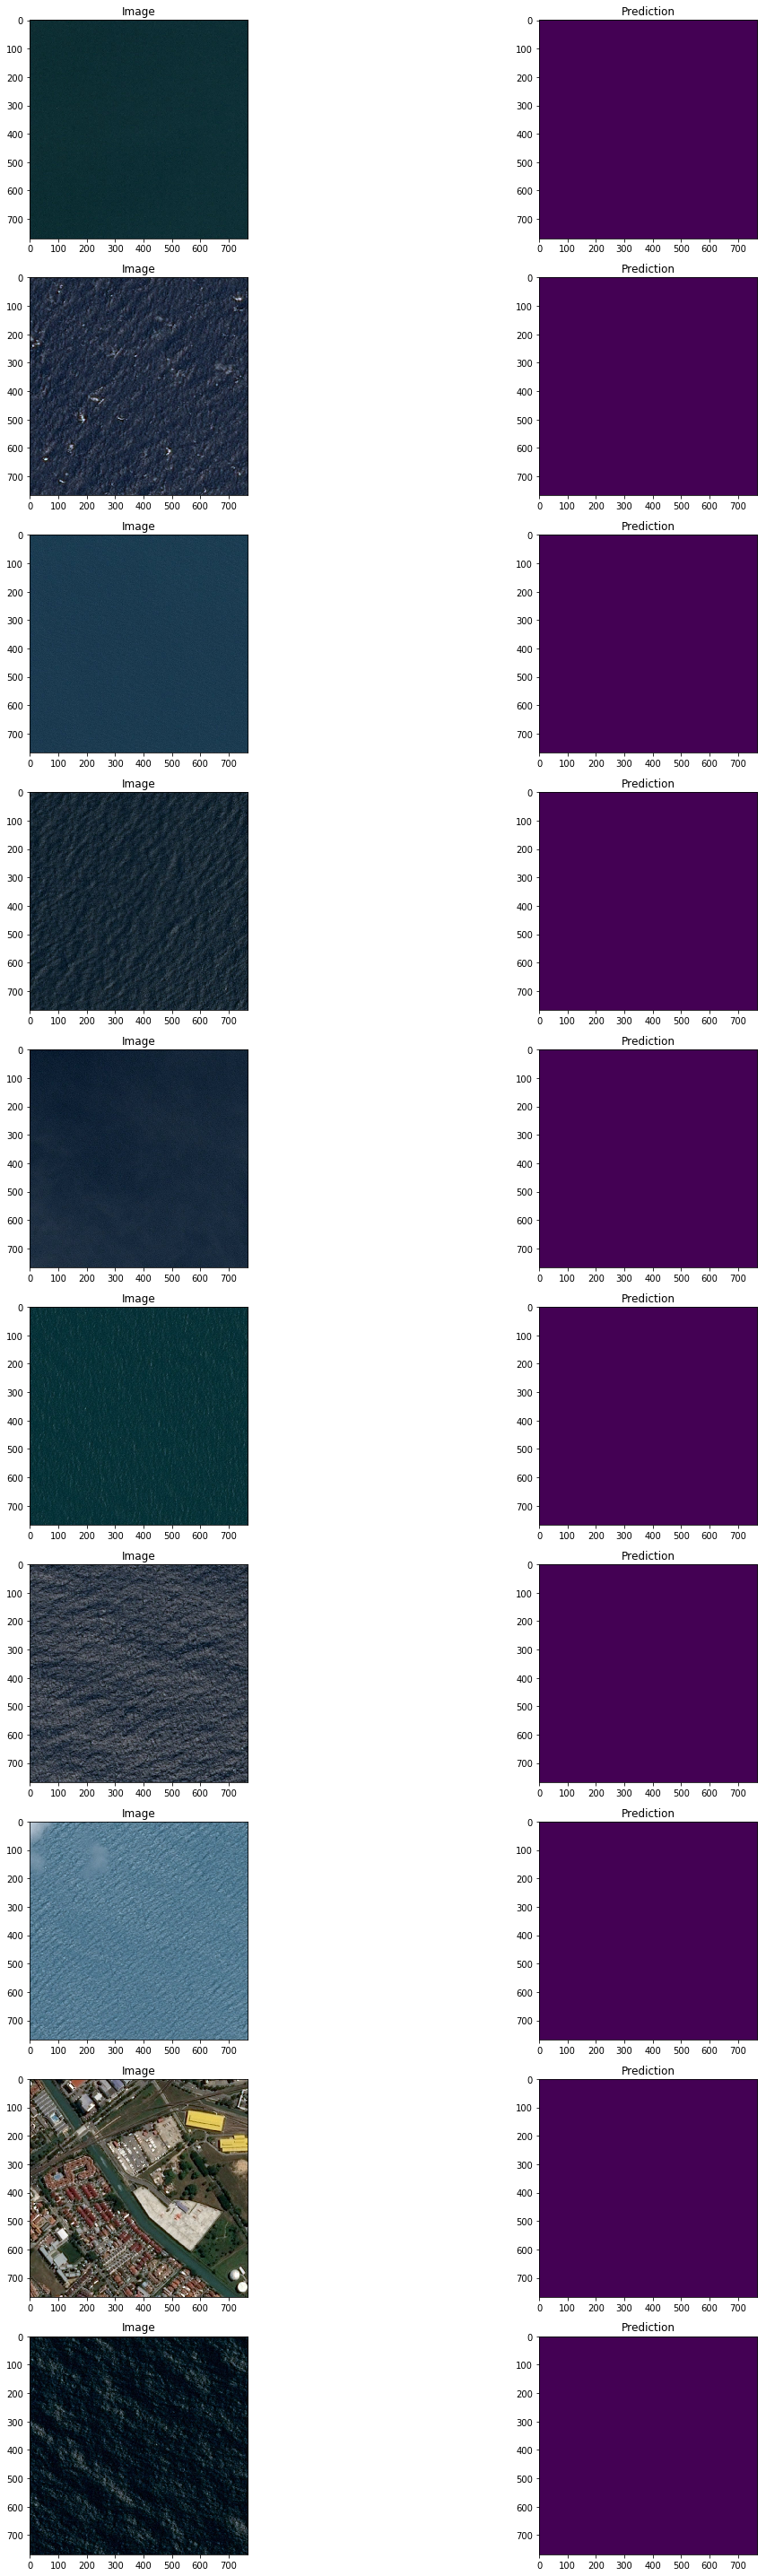

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random as rn
import os
from skimage.morphology import binary_opening, disk, label
from keras.applications.imagenet_utils import preprocess_input
% matplotlib inline

if PICTURES:
    NR_PICTURES = len(PICTURES)
    images = np.zeros((NR_PICTURES, 1, 768, 768, 3))
    for idx, path in enumerate(PICTURES):
        img_path = os.path.join("input/test", path)
        images[idx][0] = mpimg.imread(img_path)
        
else:
    image_list = os.listdir("input/test")
    image_paths = rn.sample(image_list, NR_PICTURES)
    images = np.zeros((NR_PICTURES, 1, 768, 768, 3))
    for idx, path in enumerate(image_paths):
        img_path = os.path.join("input/test", path)
        images[idx][0] = mpimg.imread(img_path)

fig, axes = plt.subplots(NR_PICTURES, 2, figsize=(20, 4 * NR_PICTURES))

counter = 0
for idx, ax in enumerate(axes.flat):
    if idx % 2 == 0:
        ax.set_title('Image')
        ax.imshow(np.squeeze(images[counter]).astype(np.uint8))
    else:
        ax.set_title('Prediction')
        img = preprocess_input(images[counter])
        prediction = model.predict(img)[0]
        counter += 1
        ax.imshow(np.squeeze(prediction))
plt.tight_layout()
plt.show()
